# Data mining techniques: Assignment 2

This environment makes use of the R statistical analytics software tool

In [22]:
library("ggplot2")
library("grid")
library("gridExtra")
library("scales")
library("plyr")
library("corrplot")
library("gbm")
library("xgboost")

# Load the data

In [23]:
trainPath <- "/home/kevin/data_mining/data/assignment2/train.csv"
testPath <- "/home/kevin/data_mining/data/assignment2/test.csv"

trainNames <- colnames(read.csv(trainPath,nrows = 1))
testNames <- colnames(read.csv(testPath,nrows = 1))

train <- read.csv(trainPath,header=F,skip=1,nrows = 200000)
#test <- read.csv(testPath,header=F,skip=1,nrows = 20)

#train <- read.csv(trainPath)
#test <- read.csv(testPath)

colnames(train) <- trainNames
#colnames(test) <- testNames

head(train)

srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,⋯,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
1,2013-04-04 08:32:15,12,187,NULL,NULL,219,893,3,3.5,⋯,NULL,NULL,NULL,NULL,0,0,NULL,0,NULL,0
1,2013-04-04 08:32:15,12,187,NULL,NULL,219,10404,4,4.0,⋯,NULL,NULL,NULL,NULL,0,0,NULL,0,NULL,0
1,2013-04-04 08:32:15,12,187,NULL,NULL,219,21315,3,4.5,⋯,NULL,NULL,NULL,NULL,0,0,NULL,0,NULL,0
1,2013-04-04 08:32:15,12,187,NULL,NULL,219,27348,2,4.0,⋯,NULL,NULL,NULL,NULL,-1,0,5,0,NULL,0
1,2013-04-04 08:32:15,12,187,NULL,NULL,219,29604,4,3.5,⋯,NULL,NULL,NULL,NULL,0,0,NULL,0,NULL,0
1,2013-04-04 08:32:15,12,187,NULL,NULL,219,30184,4,4.5,⋯,NULL,NULL,NULL,NULL,0,0,7,0,NULL,0


## Convert Factors into numeric variables

In [24]:
factor_cols <- unlist(lapply(train, is.factor))
factor_cols["date_time"] <- FALSE

#train[factor_cols] <- as.numeric(as.character(train[factor_cols]))

for (name in colnames(train[factor_cols])){
    train[name] <- as.numeric(sub('NULL',NA,as.character(train[name][,1])))
}

head(train)

srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,⋯,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
1,2013-04-04 08:32:15,12,187,NA,NA,219,893,3,3.5,⋯,NA,NA,NA,NA,0,0,NA,0,NA,0
1,2013-04-04 08:32:15,12,187,NA,NA,219,10404,4,4.0,⋯,NA,NA,NA,NA,0,0,NA,0,NA,0
1,2013-04-04 08:32:15,12,187,NA,NA,219,21315,3,4.5,⋯,NA,NA,NA,NA,0,0,NA,0,NA,0
1,2013-04-04 08:32:15,12,187,NA,NA,219,27348,2,4.0,⋯,NA,NA,NA,NA,-1,0,5,0,NA,0
1,2013-04-04 08:32:15,12,187,NA,NA,219,29604,4,3.5,⋯,NA,NA,NA,NA,0,0,NA,0,NA,0
1,2013-04-04 08:32:15,12,187,NA,NA,219,30184,4,4.5,⋯,NA,NA,NA,NA,0,0,7,0,NA,0


# Initial data exploration

## Plot missing values

In [25]:
# Get NA value booleans
nas <- is.na(train)

len.nas <- length(nas[,1])

# Initialize NA vector
na.vec <- vector(mode="integer",length=length(colnames(train)))

# Sum the NA values and fill NA vector
for (i in 1:length(na.vec)){
    na.vec[i] <- sum(nas[,i]) / len.nas
}

# Create bar plot Data Frame
na.df <- data.frame(colnames(train),na.vec)
colnames(na.df) <- c("attribute","missing_values")

# Sort by number of missing values
position <- arrange(na.df,missing_values)["attribute"][,1]

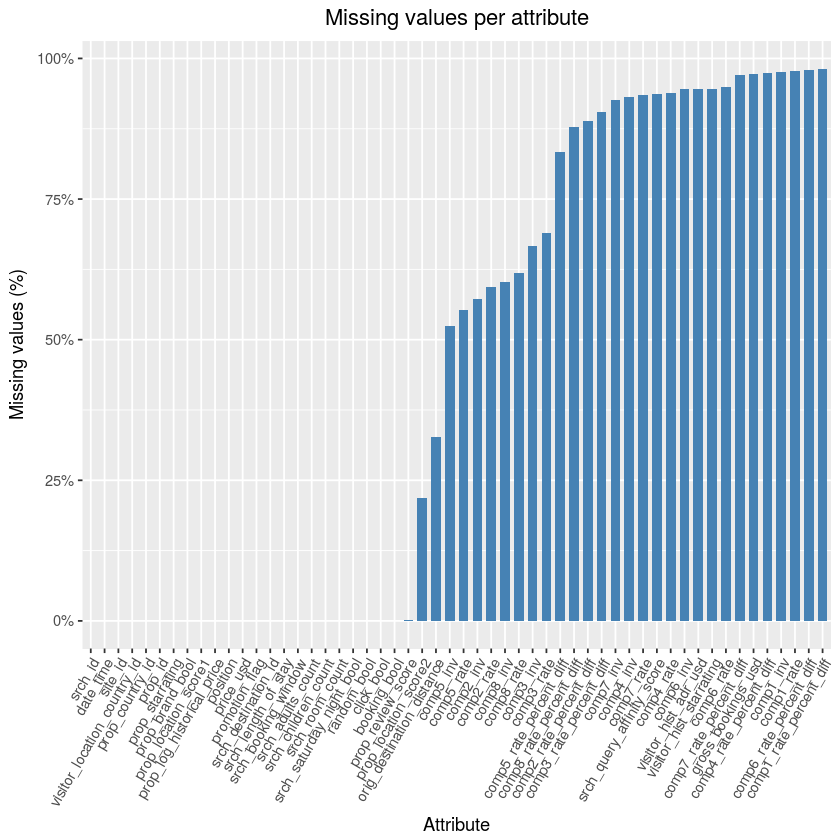

In [26]:
# Plot missing values bar plot
ggplot(data=na.df,aes(x=factor(attribute),y=missing_values)) + 
geom_bar(stat="identity",width=0.7, fill="steelblue") +
theme(axis.text.x = element_text(angle = 60, hjust = 1), plot.title = element_text(hjust = 0.5)) + 
scale_x_discrete(limits=position) + scale_y_continuous(labels=percent) +
labs(title="Missing values per attribute", x="Attribute", y="Missing values (%)")

## Data summaries

In [27]:
summary(train)

    srch_id                    date_time         site_id     
 Min.   :    1   2013-03-03 19:26:40:    63   Min.   : 1.00  
 1st Qu.: 3314   2013-05-14 20:51:04:    37   1st Qu.: 5.00  
 Median : 6700   2012-12-05 15:13:34:    36   Median : 5.00  
 Mean   : 6701   2013-05-09 22:14:57:    36   Mean   : 9.91  
 3rd Qu.:10053   2013-06-17 16:51:28:    36   3rd Qu.:14.00  
 Max.   :13431   2013-06-25 15:39:35:    36   Max.   :34.00  
                 (Other)            :199756                  
 visitor_location_country_id visitor_hist_starrating visitor_hist_adr_usd
 Min.   :  2.0               Min.   :1.67            Min.   : 31.54      
 1st Qu.:100.0               1st Qu.:3.00            1st Qu.:115.21      
 Median :219.0               Median :3.50            Median :164.72      
 Mean   :175.7               Mean   :3.44            Mean   :183.60      
 3rd Qu.:219.0               3rd Qu.:4.00            3rd Qu.:226.33      
 Max.   :230.0               Max.   :5.00            Max.   

In [28]:
#summary(test)

# Exploratory data analysis: Investigate Missing Values

## Competitor attributes

In [29]:
comp_data <- function(df,attr_name){
    
    booked <- df[,"booking_bool"] == 1
    clicked <- df[,"click_bool"] == 1

    books <- data.frame()
    clicks <- data.frame()

    for (i in c(1:8)){
        str <- sprintf("comp%i_%s",i,attr_name)
        
        # Full value counts
        full <- as.data.frame(table(df[,str], useNA="always"))
    
        full[,"Competitor"] <- factor(i,levels=c(1:8))
    
        full[,"Var1"] <- factor(full[,"Var1"],levels=c(-1,0,1,"NA"))
        full[is.na(full[,"Var1"]),"Var1"] <- factor("NA",levels=c(-1,0,1,"NA"))
    
        # Booked value counts
        book <- as.data.frame(table(df[booked,str], useNA="always"))
    
        book[,"Competitor"] <- factor(i,levels=c(1:8))
    
        book[,"Var1"] <- factor(book[,"Var1"],levels=c(-1,0,1,"NA"))
        book[is.na(book[,"Var1"]),"Var1"] <- factor("NA",levels=c(-1,0,1,"NA"))
    
        book[,"Freq"] <- book[,"Freq"] / full[,"Freq"]
    
        # Click value counts
        click <- as.data.frame(table(df[clicked,str], useNA="always"))
        
        click[,"Competitor"] <- factor(i,levels=c(1:8))
    
        click[,"Var1"] <- factor(click[,"Var1"],levels=c(-1,0,1,"NA"))
        click[is.na(click[,"Var1"]),"Var1"] <- factor("NA",levels=c(-1,0,1,"NA"))
    
        click[,"Freq"] <- click[,"Freq"] / full[,"Freq"]
    
        books <- rbind(books,book)
        clicks <- rbind(clicks,click)
    }
    
    return(list(books,clicks))
}

### Competitor rates

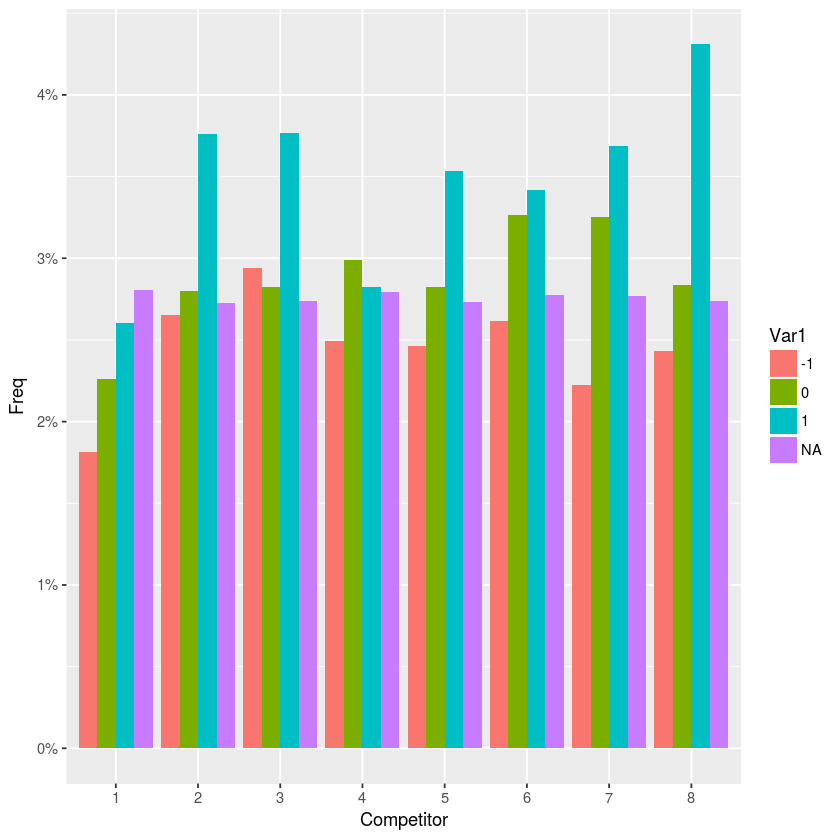

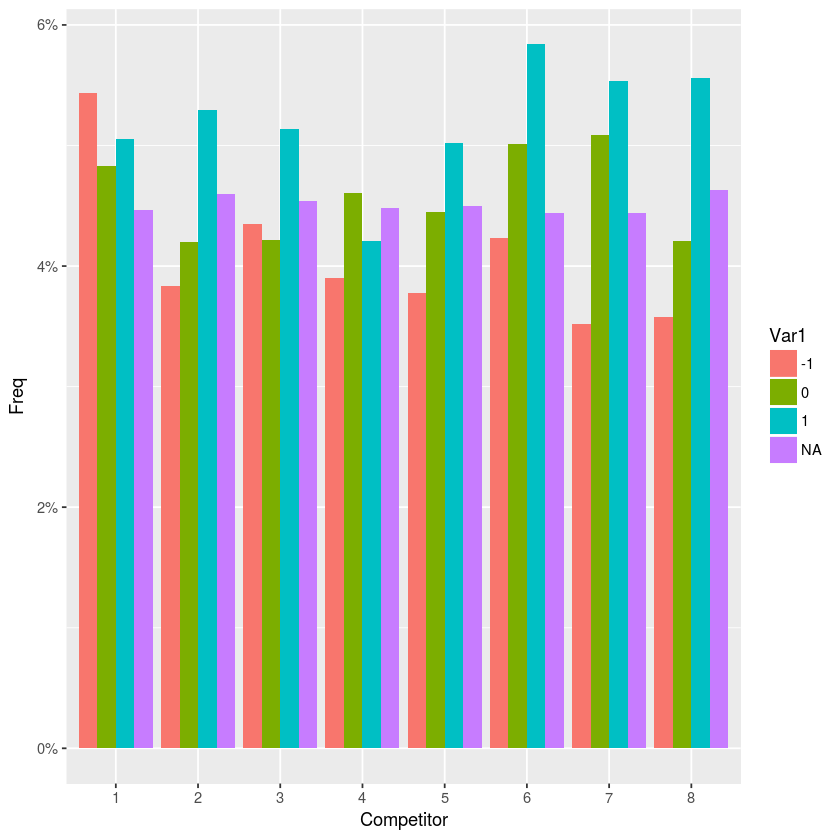

In [30]:
data <- comp_data(train,"rate")

books <- data[[1]]
clicks <- data[[2]]

ggplot(data=books, aes(x=Competitor,y=Freq,fill=Var1)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent)

ggplot(data=clicks, aes(x=Competitor,y=Freq,fill=Var1)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent)

### Competitor inv

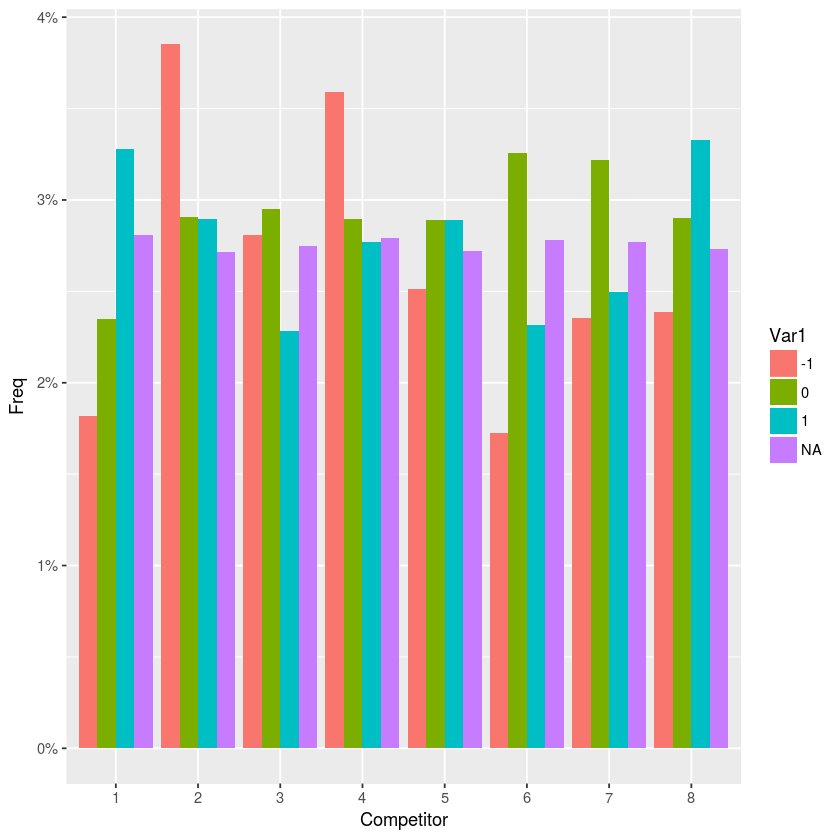

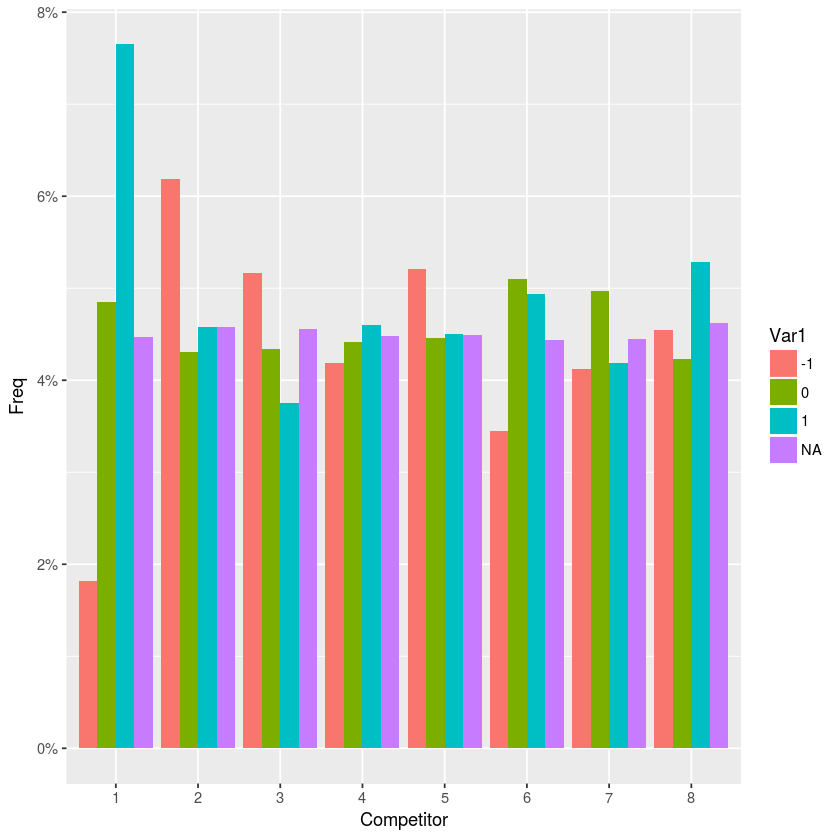

In [31]:
data <- comp_data(train,"inv")

books <- data[[1]]
clicks <- data[[2]]

ggplot(data=books, aes(x=Competitor,y=Freq,fill=Var1)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent)

ggplot(data=clicks, aes(x=Competitor,y=Freq,fill=Var1)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent)

## Descriptive hotel attributes (description for customers)

In [32]:
na_booking_data <- function(df,attr_name){
    booked <- df[,"booking_bool"] == 1
    clicked <- df[,"click_bool"] == 1
    
    nas.full <- is.na(df[,attr_name])
    nas.book <- nas.full[booked]
    nas.click <- nas.full[clicked]
    
    labels <- c("Not NA","NA")
    
    book.ratio.na <- sum(nas.book) / sum(nas.full)
    book.ratio.nna <- sum(!nas.book) / sum(!nas.full)
    
    click.ratio.na <- sum(nas.click) / sum(nas.full)
    click.ratio.nna <- sum(!nas.click) / sum(!nas.full)
    
    # Booked value counts
    books <- data.frame(target_attribute="booking_bool",attribute=attr_name,var=labels,
                        ratio = c(book.ratio.nna,book.ratio.na))

    # Click value counts
    clicks <- data.frame(target_attribute="click_bool",attribute=attr_name,var=labels,
                        ratio = c(click.ratio.nna,click.ratio.na))
    
    result <- rbind(books,clicks)
    return(result)
}

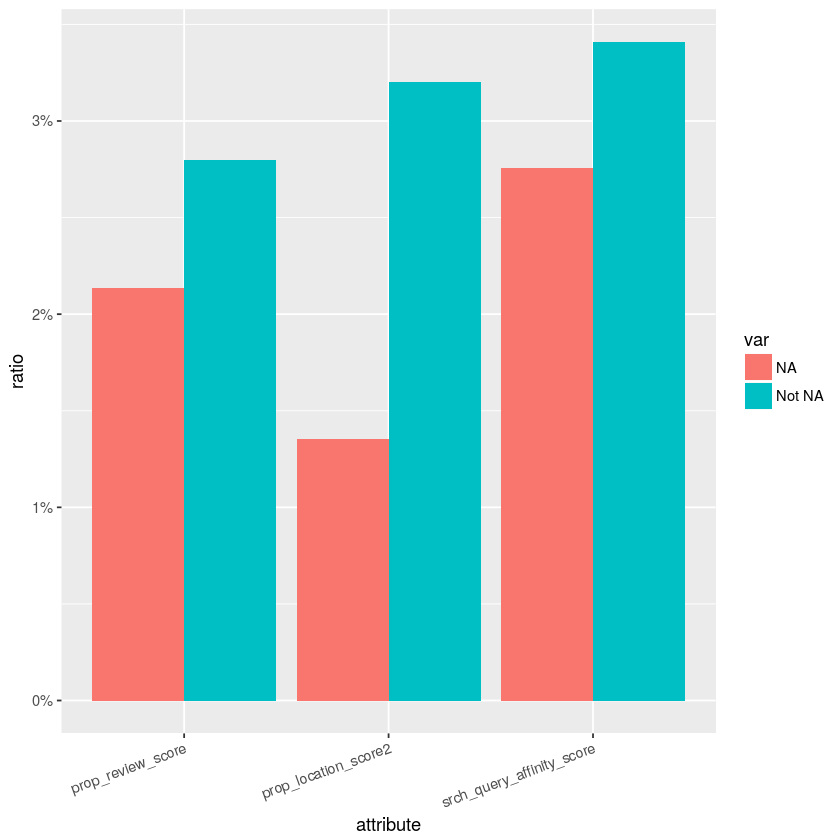

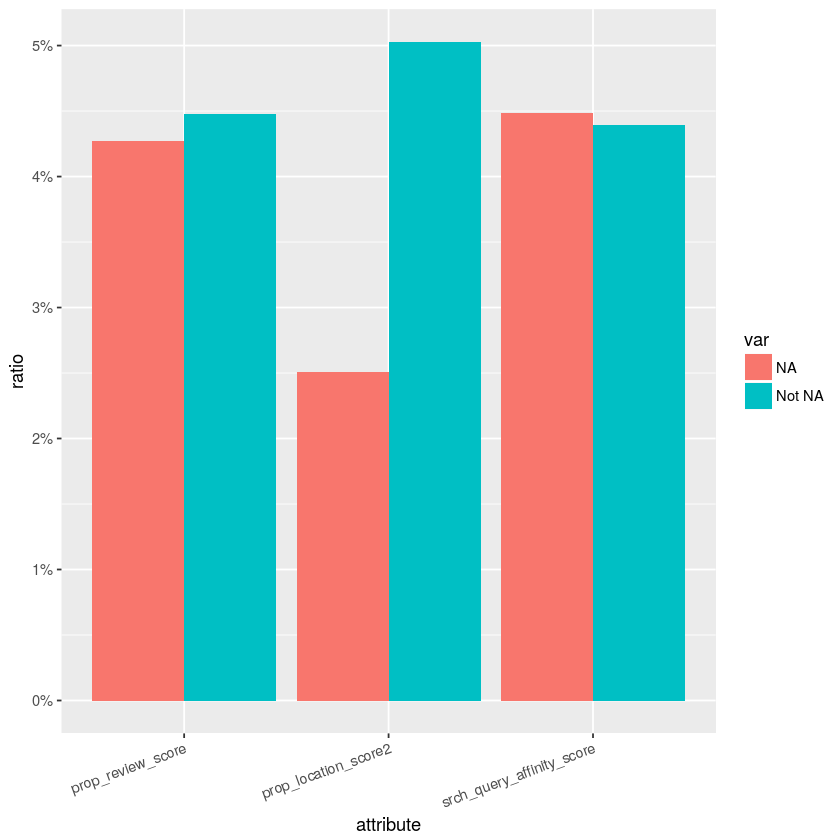

In [33]:
hotel.df <- rbind(na_booking_data(train,"prop_review_score"),
                  na_booking_data(train,"prop_location_score2"),
                  na_booking_data(train,"srch_query_affinity_score"))

books <- hotel.df[hotel.df[,"target_attribute"] == "booking_bool",]
clicks <- hotel.df[hotel.df[,"target_attribute"] == "click_bool",]

ggplot(data=books, aes(x=attribute,y=ratio,fill=var)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent) +
theme(axis.text.x = element_text(angle = 20, hjust = 1), plot.title = element_text(hjust = 0.5))

ggplot(data=clicks, aes(x=attribute,y=ratio,fill=var)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent) +
theme(axis.text.x = element_text(angle = 20, hjust = 1), plot.title = element_text(hjust = 0.5))

## Origin-destination distance

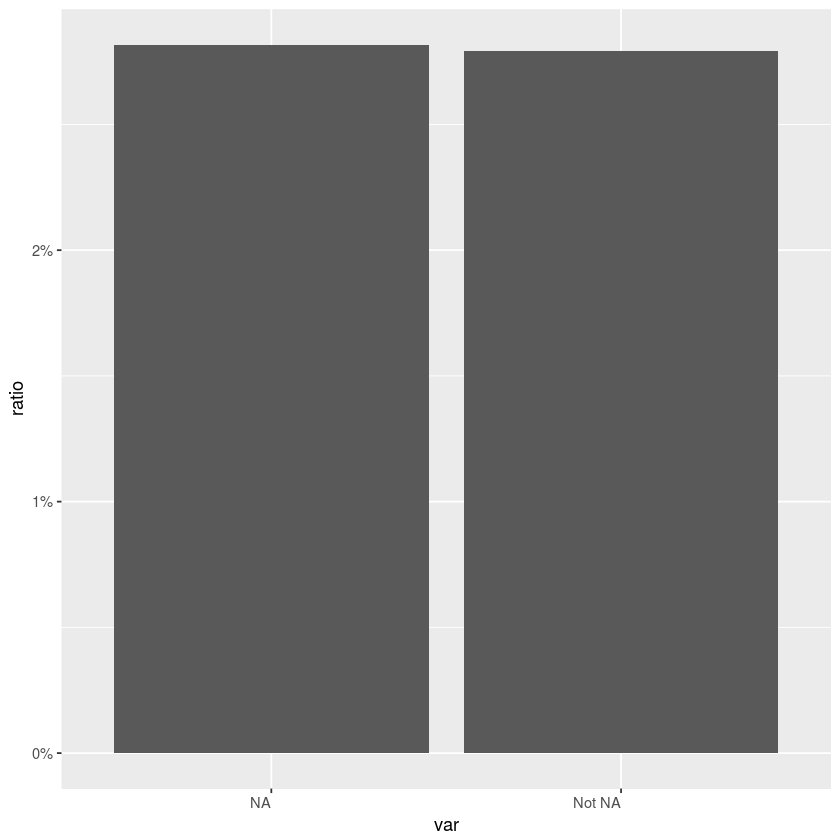

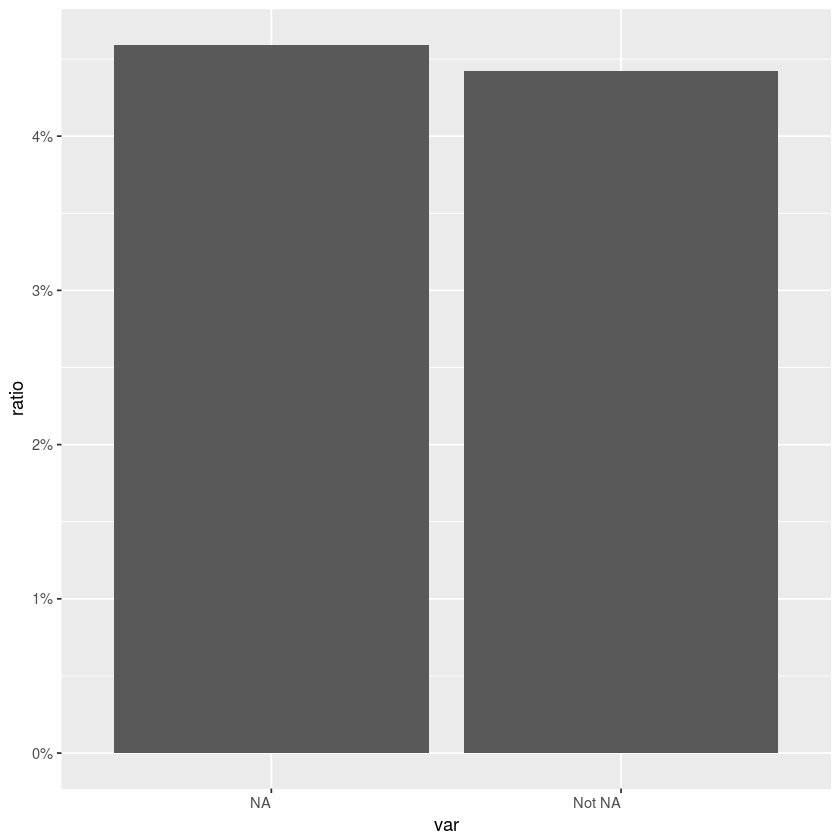

In [34]:
distance.df <- na_booking_data(train,"orig_destination_distance")

books <- distance.df[distance.df[,"target_attribute"] == "booking_bool",]
clicks <- distance.df[distance.df[,"target_attribute"] == "click_bool",]

ggplot(data=books, aes(x=var,y=ratio)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent) +
theme(axis.text.x = element_text(angle = 0, hjust = 1), plot.title = element_text(hjust = 0.5))

ggplot(data=clicks, aes(x=var,y=ratio)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent) +
theme(axis.text.x = element_text(angle = 0, hjust = 1), plot.title = element_text(hjust = 0.5))

Warning message:
“Removed 65371 rows containing non-finite values (stat_bin).”

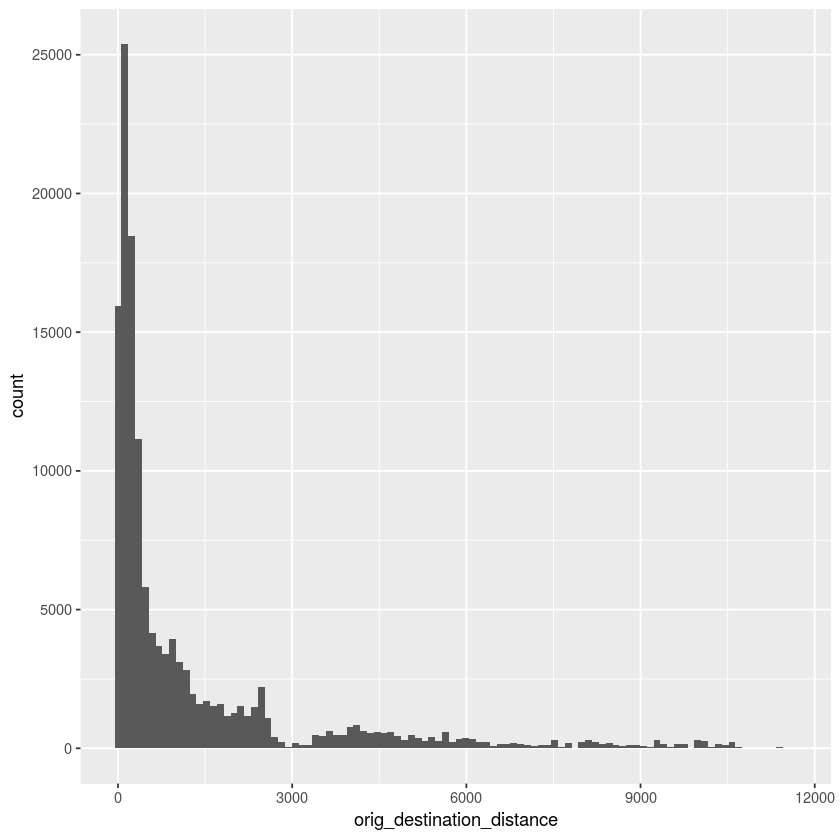

In [35]:
ggplot(data=train, aes(x=orig_destination_distance, na.rm=TRUE)) +
geom_bar(stat="bin",bins=100) + theme(plot.title = element_text(hjust = 0.5))

# Fill in missing values

In [36]:
train["prop_review_score"][is.na(train["prop_review_score"])] <- 0

## Fill origin-destination distance

In [37]:
visitor_country_id <- train["visitor_location_country_id"][,]
prop_country_id <- train["prop_country_id"][,]

max_n <- max(max(as.numeric(prop_country_id)),max(as.numeric(visitor_country_id)))

sum.distances <- matrix(0,nrow=max_n,ncol=max_n)
count.distances <- matrix(0,nrow=max_n,ncol=max_n)

sprintf("NAs before: %i",sum(is.na(train[,"orig_destination_distance"])))

# Calculate mean distance per pair of IDs
for (i in 1:nrow(train)){
    vis_id <- train[i,"visitor_location_country_id"]
    prop_id <- train[i,"prop_country_id"]
    distance <- train[i,"orig_destination_distance"]
    
    j <- max(vis_id,prop_id)
    k <- min(vis_id,prop_id)
    
    if (!is.na(distance)){
        sum.distances[j,k] <- sum.distances[j,k] + distance
        count.distances[j,k] <- count.distances[j,k] + 1
    }
}

mean.distances <- sum.distances / count.distances

# Fill NAs with corresponding ID pair values
for (i in 1:nrow(train)){
    vis_id <- train[i,"visitor_location_country_id"]
    prop_id <- train[i,"prop_country_id"]
    distance <- train[i,"orig_destination_distance"]
    
    j <- max(vis_id,prop_id)
    k <- min(vis_id,prop_id)
    
    if (is.na(distance)){
        train[i,"orig_destination_distance"] <- mean.distances[j,k]
    }
}

# Fill NAs with means per visitor location ID
if (sum(is.na(train[,"orig_destination_distance"])) != 0) {
    max_visitor_country_id <- max(as.numeric(visitor_country_id))
    for (i in 1:max_visitor_country_id){
        mean.distances.i <- mean(train[visitor_country_id == i,"orig_destination_distance"],na.rm=T)
        
        temp <- visitor_country_id == i
        idx <- temp & is.na(train[,"orig_destination_distance"])
        
        train[idx,"orig_destination_distance"] <- mean.distances.i
    }
}

# Fill remaining NAs with the mean of all distances
if (sum(is.na(train[,"orig_destination_distance"])) != 0) {
    idx <- is.na(train[,"orig_destination_distance"])
    mean.distance <- mean(train[,"orig_destination_distance"],na.rm=T)
    train[idx,"orig_destination_distance"] <- mean.distance
}

sprintf("NAs after: %i",sum(is.na(train[,"orig_destination_distance"])))

[1] "NAs before: 65371"

[1] "NAs after: 0"

# Exploratory data analysis: Feature Relations

# Feature extraction and Engineering

## Extract time features from date_time

In [38]:
date.strings <- train["date_time"][,]

date <- strptime(date.strings,format="%Y-%m-%d %H:%M:%OS")

date.df <- data.frame(year=as.numeric(format(date,format="%Y")),month=as.numeric(format(date,format="%m")),
                      day=as.numeric(format(date,format="%d")),hour=as.numeric(format(date,format="%H")),
                      minute=as.numeric(format(date,format="%M")),second=as.numeric(format(date,format="%OS")))

colnames(date.df) = paste("date_",colnames(date.df),sep="")

head(date.df)

date_year,date_month,date_day,date_hour,date_minute,date_second
2013,4,4,8,32,15
2013,4,4,8,32,15
2013,4,4,8,32,15
2013,4,4,8,32,15
2013,4,4,8,32,15
2013,4,4,8,32,15


In [39]:
# Replace date_time with relevant time values

train <- subset(train,select=-date_time)

for (col in c("date_year","date_month","date_hour")){
    train[,col] <- date.df[col]
}

num.attr <- length(colnames(train))

train <- train[,colnames(train)[c(1,(num.attr-2):num.attr,2:(num.attr-3))]]

# Exploratory data analysis: Feature Importance

## Plot something

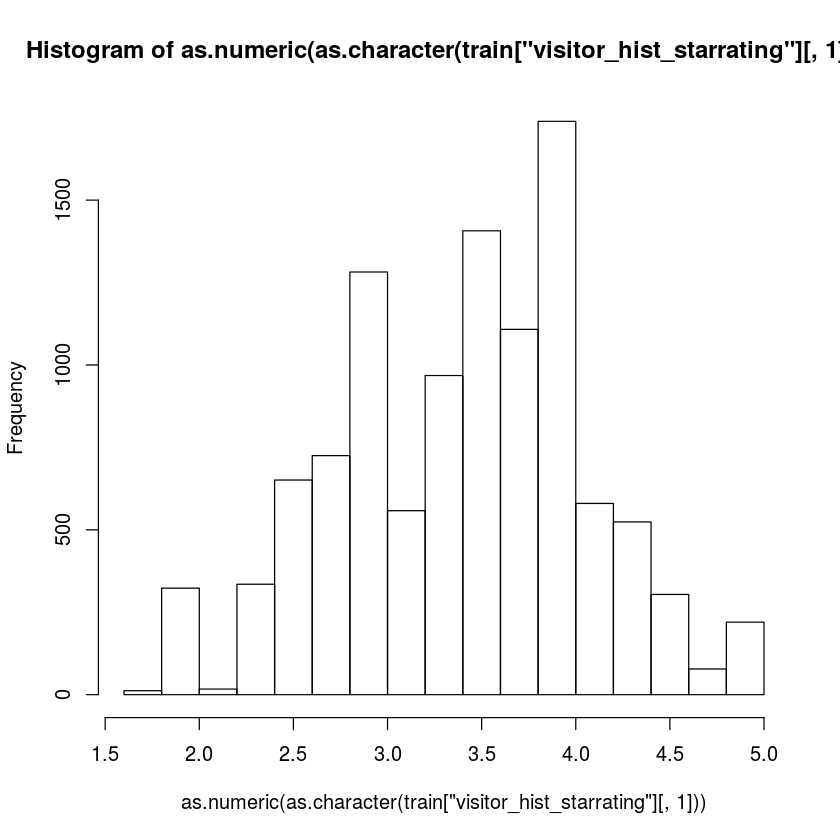

In [40]:
#ggplot(data=train,aes(x=visitor_hist_starrating)) + geom_histogram(bins=30)
hist(as.numeric(as.character(train["visitor_hist_starrating"][,1])))

# Correlation plot of the numeric attributes

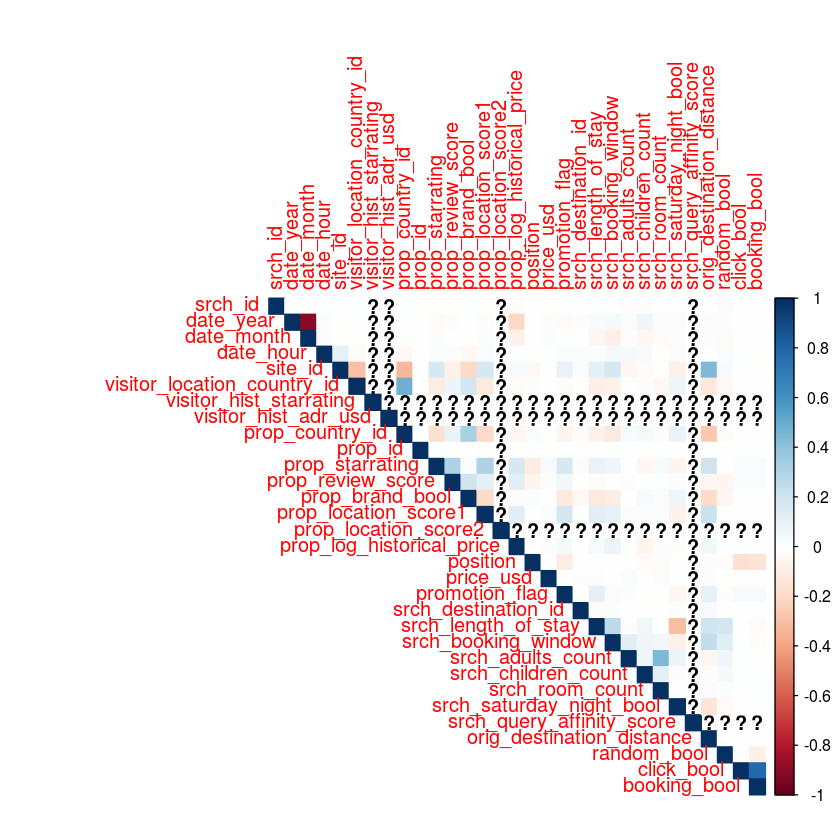

In [41]:
train.nums <- unlist(lapply(train, is.numeric))
l.idx <- length(colnames(train))

corrplot(cor(train[colnames(train)[c(1:29,l.idx-2,l.idx)]]),method="color",type="upper")

# Modeling and Evaluation

## Add relevance targets

In [42]:
relevance <- numeric(nrow(train))

booked <- train[,"booking_bool"] == 1
clicked <- !booked & (train[,"click_bool"] == 1)

relevance[booked] <- 5
relevance[clicked] <- 1

train[,"relevance"] <- relevance

## Split the data for modeling

In [43]:
# Determine approximate values for the test and validation sets
ntest <- as.integer(0.15 * nrow(train))
nvalid <- as.integer(0.15 * nrow(train))

# Initial test set split index
test.idx <- nrow(train) - ntest

# First search id for the test set
split.id <- train[test.idx,"srch_id"]

# Determine first incidence of search_id
for (i in test.idx:2){
    if (train[i-1,"srch_id"] != split.id){
        test.idx <- i
        break
    }
}

# Get test set from train
train.test <- train[test.idx:nrow(train),]

# Get train set from train
train.train <- train[1:test.idx,]

head(train.test)

,srch_id,date_year,date_month,date_hour,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,⋯,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,relevance
169977,11370,2013,1,12,5,219,NA,NA,219,2506,⋯,NA,NA,NA,NA,NA,NA,0,NA,0,0
169978,11370,2013,1,12,5,219,NA,NA,219,9223,⋯,NA,NA,NA,NA,NA,NA,0,NA,0,0
169979,11370,2013,1,12,5,219,NA,NA,219,9456,⋯,NA,NA,NA,NA,NA,NA,0,NA,0,0
169980,11370,2013,1,12,5,219,NA,NA,219,12950,⋯,NA,NA,NA,NA,NA,NA,0,NA,0,0
169981,11370,2013,1,12,5,219,NA,NA,219,19626,⋯,NA,NA,NA,NA,NA,NA,0,NA,0,0
169982,11370,2013,1,12,5,219,NA,NA,219,21244,⋯,NA,NA,NA,NA,NA,NA,1,530.6,1,5


## Train the lambdaMART using XGBoost

In [44]:
xgb.train <- subset(train.train, select=c(-srch_id,-position,-click_bool,-gross_bookings_usd,-booking_bool,-relevance))
#dtest <- subset()

xgb.train <- data.matrix(xgb.train)

head(xgb.train)

,date_year,date_month,date_hour,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,⋯,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff
1,2013,4,8,12,187,NA,NA,219,893,3,⋯,NA,NA,NA,NA,NA,NA,NA,0,0,NA
2,2013,4,8,12,187,NA,NA,219,10404,4,⋯,NA,NA,NA,NA,NA,NA,NA,0,0,NA
3,2013,4,8,12,187,NA,NA,219,21315,3,⋯,NA,NA,NA,NA,NA,NA,NA,0,0,NA
4,2013,4,8,12,187,NA,NA,219,27348,2,⋯,NA,NA,NA,NA,NA,NA,NA,-1,0,5
5,2013,4,8,12,187,NA,NA,219,29604,4,⋯,NA,NA,NA,NA,NA,NA,NA,0,0,NA
6,2013,4,8,12,187,NA,NA,219,30184,4,⋯,NA,NA,NA,NA,NA,NA,NA,0,0,7


In [45]:
xgb.model <- xgboost(booster="gbtree",data = xgb.train, label=train.train$relevance, nrounds=100, 
                 objective = "rank:pairwise",eval_metric="ndcg",missing=NA)

[1]	train-ndcg:0.736705 
[2]	train-ndcg:0.741281 
[3]	train-ndcg:0.742552 
[4]	train-ndcg:0.743907 
[5]	train-ndcg:0.747083 
[6]	train-ndcg:0.746615 
[7]	train-ndcg:0.748883 
[8]	train-ndcg:0.752813 
[9]	train-ndcg:0.754540 
[10]	train-ndcg:0.755278 
[11]	train-ndcg:0.756662 
[12]	train-ndcg:0.758717 
[13]	train-ndcg:0.758475 
[14]	train-ndcg:0.759619 
[15]	train-ndcg:0.759360 
[16]	train-ndcg:0.760328 
[17]	train-ndcg:0.760810 
[18]	train-ndcg:0.760601 
[19]	train-ndcg:0.761138 
[20]	train-ndcg:0.762089 
[21]	train-ndcg:0.762617 
[22]	train-ndcg:0.763494 
[23]	train-ndcg:0.763980 
[24]	train-ndcg:0.764544 
[25]	train-ndcg:0.764797 
[26]	train-ndcg:0.765491 
[27]	train-ndcg:0.765862 
[28]	train-ndcg:0.766517 
[29]	train-ndcg:0.766908 
[30]	train-ndcg:0.767448 
[31]	train-ndcg:0.768147 
[32]	train-ndcg:0.769532 
[33]	train-ndcg:0.770199 
[34]	train-ndcg:0.771405 
[35]	train-ndcg:0.772074 
[36]	train-ndcg:0.772601 
[37]	train-ndcg:0.773086 
[38]	train-ndcg:0.773185 
[39]	train-ndcg:0.774

In [46]:
predictions <- predict(xgb.model,xgb.train)

predictions.df <- data.frame(srch_id=train.train$srch_id,prop_id=train.train$prop_id,
                            predictions=predictions,relevance=train.train$relevance)

predictions.df[predictions.df$srch_id == 1,]

srch_id,prop_id,predictions,relevance
1,893,0.61635172,0
1,10404,0.75371659,0
1,21315,0.53471291,0
1,27348,-1.88407183,0
1,29604,1.12663329,0
1,30184,0.49407536,0
1,44147,0.37095207,0
1,50984,0.17279166,0
1,53341,1.15090132,0
1,56880,0.59224099,0


## Train lambdaMART using GBM

In [47]:
gbm.train <- subset(train.train, select=c(-position,-click_bool,-gross_bookings_usd,-booking_bool))

head(gbm.train)

gbm.model <- gbm(relevance~date_year:comp8_rate_percent_diff,
                data=gbm.train,
                distribution=list(   # loss function:
                  name='pairwise',   # pairwise
                  metric="ndcg",     # ranking metric:
                  group='srch_id'),    # column indicating query groups
                n.trees=1000,        # number of trees
                cv.folds = 2,
                keep.data=TRUE,      # store copy of input data in model
                verbose = FALSE,     # don't print progress
                n.cores = 2)         # number of cores used

srch_id,date_year,date_month,date_hour,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,⋯,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,relevance
1,2013,4,8,12,187,NA,NA,219,893,⋯,NA,NA,NA,NA,NA,NA,0,0,NA,0
1,2013,4,8,12,187,NA,NA,219,10404,⋯,NA,NA,NA,NA,NA,NA,0,0,NA,0
1,2013,4,8,12,187,NA,NA,219,21315,⋯,NA,NA,NA,NA,NA,NA,0,0,NA,0
1,2013,4,8,12,187,NA,NA,219,27348,⋯,NA,NA,NA,NA,NA,NA,-1,0,5,0
1,2013,4,8,12,187,NA,NA,219,29604,⋯,NA,NA,NA,NA,NA,NA,0,0,NA,0
1,2013,4,8,12,187,NA,NA,219,30184,⋯,NA,NA,NA,NA,NA,NA,0,0,7,0


[1] 1

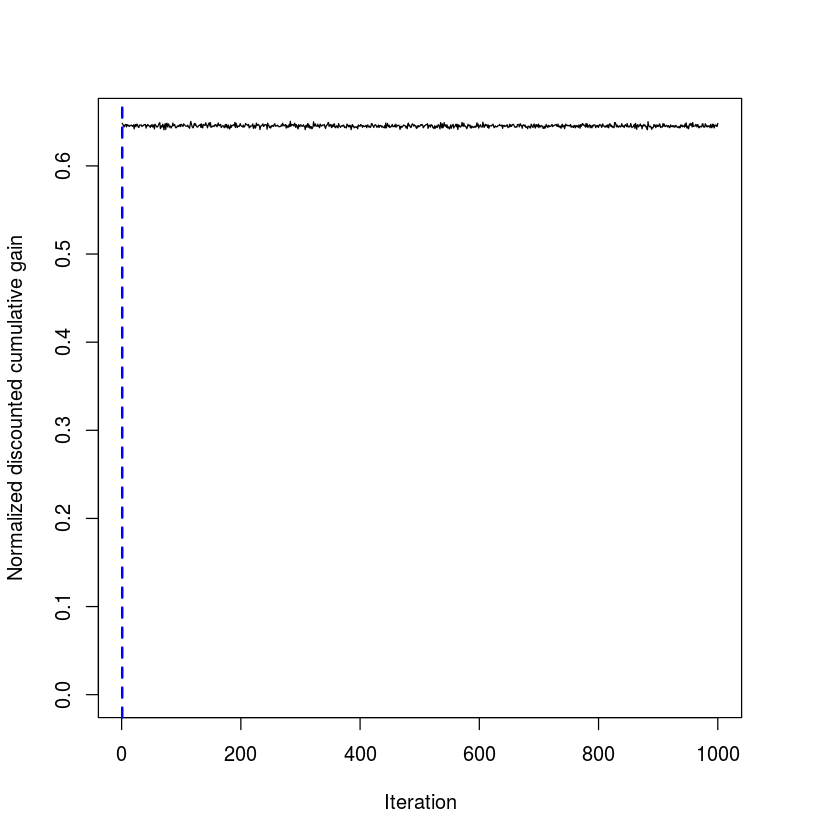

In [48]:
gbm.perf(gbm.model,method="test")

In [49]:
predictions <- predict(gbm.model,gbm.train,n.trees=1000)

predictions.df <- data.frame(srch_id=gbm.train$srch_id,prop_id=gbm.train$prop_id,
                            predictions=predictions,relevance=gbm.train$relevance)

predictions.df[predictions.df$srch_id == 1,]

srch_id,prop_id,predictions,relevance
1,893,-0.013723629,0
1,10404,-0.013723629,0
1,21315,-0.013723629,0
1,27348,-0.005800298,0
1,29604,-0.013723629,0
1,30184,-0.005800298,0
1,44147,-0.013723629,0
1,50984,-0.013723629,0
1,53341,-0.005800298,0
1,56880,-0.013723629,0
